
<h6 style="color:green">
    Lets start by importing the dataset. This data-set was scraped from <a href="http://ufcstats.com">http://www.ufcstats.com</a> using the <a style="color:red">ufc_extraction.py</a> script in this project. This script scrapes fighter statistics and stores them in a <a style="color:red"> .json</a> file. 

In [1]:
from src.data.dataMakers import dataMakers
dm = dataMakers()
fighterFrame = dm.make()
fighterFrame.head()

,dob,draws,height,losses,name,reach,sapm,slpm,stance,stracc,strdef,subavg,tdacc,tdavg,tddef,url,weight,wins
0,7-13-1978,3,NaN,0,Tom Aaron,NaN,0.00,0.00,None,0.0,0.0,0.0,0.0,0.00,0.0,http://ufcstats.com/fighter-details/93fe7332d1...,155.0,5
1,7-03-1983,6,5.92,0,Danny Abbadi,NaN,4.41,3.29,Orthodox,38.0,57.0,0.0,0.0,0.00,77.0,http://ufcstats.com/fighter-details/15df64c02b...,155.0,4
2,None,14,6.00,0,David Abbott,NaN,3.55,1.35,Switch,30.0,38.0,0.0,33.0,1.07,66.0,http://ufcstats.com/fighter-details/b361180739...,265.0,10
3,9-02-1981,4,6.25,0,Shamil Abdurakhimov,76.0,2.36,2.64,Orthodox,44.0,60.0,0.2,24.0,1.34,66.0,http://ufcstats.com/fighter-details/2f5cbecbbe...,235.0,20
4,None,14,5.50,0,Hiroyuki Abe,NaN,3.11,1.71,Orthodox,36.0,63.0,0.0,0.0,0.00,33.0,http://ufcstats.com/fighter-details/c0ed7b2081...,145.0,8


<h6 style="color:green">Great! we can print out the fighters which means the <a style="color:red">make()</a> function from the <a style="color:red">make_dataset</a> class is running smoothly. All this function does is extract the data from the  <a style="color:red">fighters.json</a> file.

In [2]:
fighterFrame.shape

(3323, 18)

<h6 style="color:green">
    We can see that the dataset is not absurdly large. This dataset contains 3323 fighters and 18 attributes.
    we can use a simple <a style="color:red"> Pandas DataFrame </a> to manipulate the dataset.
</h6>


<h2 style="color:black">
    First question: how does the distribution of fighters's weight division look like?
</h2>
<ul>
    <li>Flyweight: 115-125 lbs</li>
    <li>Bantamweight: 125-135 lbs</li>
    <li>Featherweight: 135-145 lbs</li>
    <li>Lightweight 145-155 lbs</li>
    <li>Welterweight 155-170 lbs</li>
    <li>Middleweight: 170-185 lbs</li>
    <li>Light Heavyweight: 185-205 lbs</li>
    <li>Heavyweight: 205-265 lbs</li>
</ul>

<h6 style="color:green">Before we start the analysis, we need to aggregate a "division" attribute to the original <a style="color:red"> FighterFrame</a>. The "division" attribute will allow us to easily stratify the dataset by weight. </h6>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()
#Aggregating an extra column that stores the division of each fighter.
conditions = [
    (fighterFrame['weight'] >= 115)&(fighterFrame['weight'] < 125),
    (fighterFrame['weight'] >= 125)&(fighterFrame['weight'] < 135),
    (fighterFrame['weight'] >= 135)&(fighterFrame['weight'] < 145),
    (fighterFrame['weight'] >= 145)&(fighterFrame['weight'] < 155),
    (fighterFrame['weight'] >= 155)&(fighterFrame['weight'] < 170),
    (fighterFrame['weight'] >= 170)&(fighterFrame['weight'] < 185),
    (fighterFrame['weight'] >= 185)&(fighterFrame['weight'] < 205),
    (fighterFrame['weight'] >= 205)&(fighterFrame['weight'] < 265)]
choices = ['fly','bantam','feather','light','welter','middle','light-heavy','heavy']
fighterFrame['division'] = np.select(conditions,choices,default=None)

In [4]:
#Stratify the DataFrame by weight division.
flyWeights = fighterFrame[fighterFrame.division == 'fly']
bantamWeights = fighterFrame[fighterFrame.division == 'bantam']
featherWeights = fighterFrame[fighterFrame.division == 'feather']
lightWeights = fighterFrame[fighterFrame.division == 'light']
welterWeights = fighterFrame[fighterFrame.division == 'welter']
middleWeights = fighterFrame[fighterFrame.division == 'middle']
lightheavyWeights = fighterFrame[fighterFrame.division == 'light-heavy']
heavyWeights = fighterFrame[fighterFrame.division == 'heavy']

<h2 style="color:black">
There's one problem! the extracted data is missing a sex attribute! 
</h2>
<h6 style="color:green">
If our goal is to predict the winner of a UFC match, it would not be appropiate to analyze the dataset. Using data from datagov.org, i built a <a style="color:red"> sex classifyer </a> that classifies a fighter base on its name. Before we use my sex-classifyer algorithm, we need to verify its precision. We got lucky; all the fighters in the flyweight division are female and therefore 1 set has already been classified. We can use this set to validate our classifyer.
</h6>

In [5]:
#loading classifyer
from src.classifier.sex_classifier import identifyers
identifyer = identifyers()

#modifying the sex classifyer so that it works with our dataset
def name_to_sex(full_name):
        first_name = full_name.split()[0]
        predicted_sex = identifyer.sex_classifyer(first_name)
        return predicted_sex

#validing
correct_count = 0
incorrect_count = 0
for full_name in flyWeights.name:
    sex = name_to_sex(full_name)
    if sex == 'F':
        correct_count += 1
    elif sex == 'M':
        incorrect_count +=1

<h6 style="color:green">
I have decided that the most impporant metric for this sex_classifyer, will be its precision. I don't mind if the classifyer has a low recall as long as it has a high precision. In other words; i dont mind if my classifyer labels fighters as 'unisex' as long as it does not incorrectly classify a fighter.
</h6>

In [6]:
sex_recall = correct_count / len(flyWeights.name)
sex_precision = correct_count / (correct_count + incorrect_count)
print('Recall: ', sex_recall)
print('Precision: ', sex_precision)

Recall:  0.7183098591549296
Precision:  0.9622641509433962


<h6 style="color:green">
96% precision is something that i can live with. We might be able to improve this classifyer in the future but it is unrealistic to expect that my model will ever be 100% precise with my method. Maybe i could feed a machine learning model with fighter attributes like name, weight, height and reach to take this classifyer to the next level. That sounds fun, however i think that 96% is a very good number to keep moving foward.
</h6>

In [7]:
#aggregate the sex attribute into our data set
fighterFrame['sex'] = fighterFrame['name'].apply(name_to_sex)

#divide the fighter data set into males and females
#some divisions are only female and some divisions are only for males. we need to account for that.
femalesFrame = fighterFrame[(fighterFrame.sex == 'F')\
                            &(fighterFrame.division != 'welter')\
                            &(fighterFrame.division != 'middle')\
                            &(fighterFrame.division != 'heavy')\
                            &(fighterFrame.division != 'light-heavy')]

malesFrame = fighterFrame[(fighterFrame.sex == 'M')\
                          &(fighterFrame.division != 'fly')]

<h6 style="color:green">
    It will help if i graph both; the frequency and relative frequency of each fighting class. This will give me the ability to explore the data from different perspectives and consequently allows me to ask different questions about the same set. The frequency plot provides information on the size of each division and the relative frequency provides us with a proportion. 
</h6>

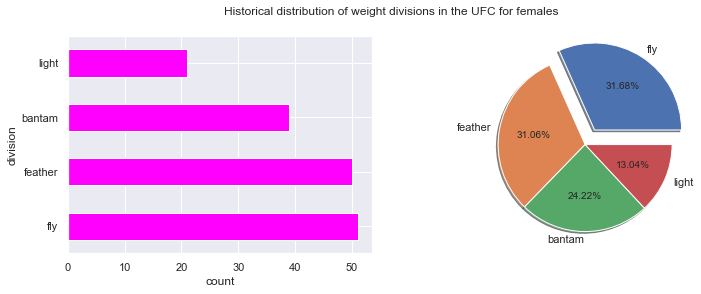

In [58]:
#Females
#setting up figure configuration
fig1, axes1 = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
fig1.suptitle('Historical distribution of weight divisions in the UFC for females')
axes1[0].set_ylabel('division')
axes1[0].set_xlabel('count')

#plotting
femalesFrame.division.value_counts().plot.barh(color="magenta", ax=axes1[0])

femalesFrame.division.value_counts(normalize=True,dropna=True)\
.plot.pie(shadow=True,explode=[.2,0,0,0],ax=axes1[1],autopct='%.2f%%')
axes1[1].set_ylabel('');

<h6 style="color:blue">
Interesting! we see that the most common weight division is welter-weight and the smallest division is fly-weight.
A generalized conclusion would be that heavier weight divisions tend to have a larger amount of fighters than lighter divisions.
</h6>

In [9]:
len(femalesFrame[femalesFrame.division =='fly'])/len(femalesFrame[femalesFrame.division == 'light'])

2.4285714285714284

<h6 style="color:blue">
Historically, there has been ~2 times more fighters in the females' fly-weight division than in the light-weight division.
</h6>

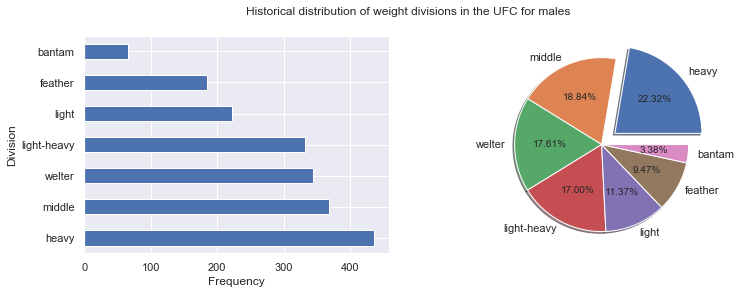

In [148]:
#Males
#setting up figure configuration
fig1, axes1 = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
fig1.suptitle('Historical distribution of weight divisions in the UFC for males')
axes1[0].set_ylabel('Division')
axes1[0].set_xlabel('Frequency')

#plotting
malesFrame.division.value_counts().plot.barh(color="b", ax=axes1[0])

malesFrame.division.value_counts(normalize=True,dropna=True)\
.plot.pie(shadow=True,explode=[.2,0,0,0,0,0,0],ax=axes1[1],autopct='%.2f%%')
axes1[1].set_ylabel('');

In [11]:
len(malesFrame[malesFrame.division == 'heavy'])/len(malesFrame[malesFrame.division =='bantam'])


6.606060606060606

<h6 style="color:blue">
Historically, There as been ~7 times more fighters in the males' heavy-weight division than in the bantam-weight division. That's quite a difference!
</h6>

<h6 style="color:green">
    We have scratched the surface of this dataset, now lets dive in deeper...
</h6>

<h2 style="color:black">
    Second Question: How does height distribution look like? and how does it look like in each sub-division?
</h2>

In [12]:
#misellaneous function, adds super y label or xlable to a figure
import pylab
def suplabel(axis,label,label_prop=None,
             labelpad=5,
             ha='center',va='center'):
    ''' Add super ylabel or xlabel to the figure
    Similar to matplotlib.suptitle
    axis       - string: "x" or "y"
    label      - string
    label_prop - keyword dictionary for Text
    labelpad   - padding from the axis (default: 5)
    ha         - horizontal alignment (default: "center")
    va         - vertical alignment (default: "center")
    '''
    fig = pylab.gcf()
    xmin = []
    ymin = []
    for ax in fig.axes:
        xmin.append(ax.get_position().xmin)
        ymin.append(ax.get_position().ymin)
    xmin,ymin = min(xmin),min(ymin)
    dpi = fig.dpi
    if axis.lower() == "y":
        rotation=90.
        x = xmin-float(labelpad)/dpi
        y = 0.5
    elif axis.lower() == 'x':
        rotation = 0.
        x = 0.5
        y = ymin - float(labelpad)/dpi
    else:
        raise Exception("Unexpected axis: x or y")
    if label_prop is None: 
        label_prop = dict()
    pylab.text(x,y,label,rotation=rotation,
               transform=fig.transFigure,
               ha=ha,va=va,
               **label_prop)

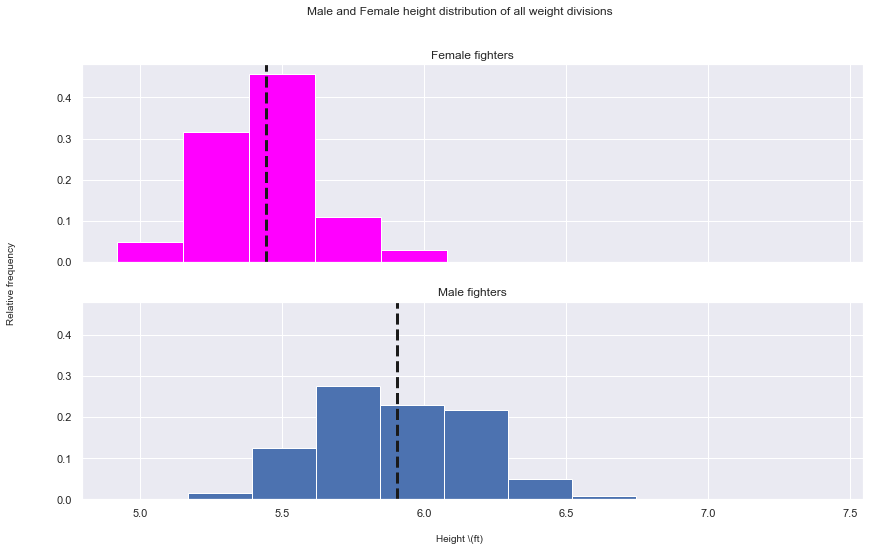

In [152]:
height_fig, height_axes = plt.subplots(2,sharey=True,sharex=True,figsize=(14,8))
height_fig.suptitle('Male and Female height distribution of all weight divisions')
suplabel('x','Height \(ft)')
suplabel('y','Relative frequency')

#females height distribution
height_axes[0].hist(femalesFrame['height'],weights=np.zeros_like(femalesFrame['height']) + 1./len(femalesFrame['height'].index),\
                    bins=5,color="magenta")
height_axes[0].axvline(femalesFrame['height'].mean(), color='k', linestyle='dashed', linewidth=3)
height_axes[0].title.set_text('Female fighters')
#males height distribution
height_axes[1].hist(malesFrame['height'],weights=np.zeros_like(malesFrame['height']) + 1./len(malesFrame['height'].index))
height_axes[1].axvline(malesFrame['height'].mean(), color='k', linestyle='dashed', linewidth=3)
height_axes[1].title.set_text('Male fighters');


<h6 style="color:blue">
    These histograms are interesting but too general; a better
    analysis would be to plot the height distribution of each sexes' fighting classes
</h6>

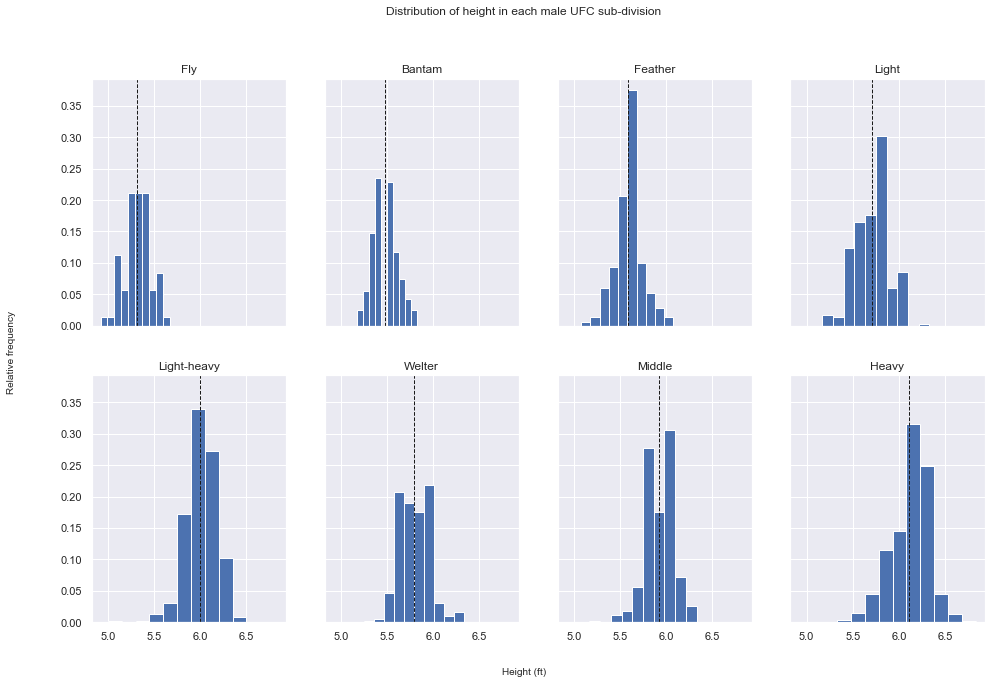

In [29]:
#figure settings
fig2, axes = plt.subplots(nrows=2, ncols=4, sharey=True, sharex=True,figsize=(16,10))
fig2.suptitle('Distribution of height in each male UFC sub-division')
suplabel('x','Height (ft)')
suplabel('y','Relative frequency')

#plotting relative frequency
axes[0][0].hist(flyWeights['height'],weights=np.zeros_like(flyWeights['height']) + 1./len(flyWeights['height'].index))
axes[0][0].title.set_text('Fly')
axes[0][0].axvline(flyWeights['height'].mean(), color='k', linestyle='dashed', linewidth=1)

axes[0][1].hist(bantamWeights['height'],weights=np.zeros_like(bantamWeights['height']) + 1./len(bantamWeights['height'].index))
axes[0][1].title.set_text('Bantam')
axes[0][1].axvline(bantamWeights['height'].mean(), color='k', linestyle='dashed', linewidth=1)

axes[0][2].hist(featherWeights['height'],weights=np.zeros_like(featherWeights['height']) + 1./len(featherWeights['height'].index))
axes[0][2].title.set_text('Feather')
axes[0][2].axvline(featherWeights['height'].mean(), color='k', linestyle='dashed', linewidth=1)

axes[0][3].hist(lightWeights['height'],weights=np.zeros_like(lightWeights['height']) + 1./len(lightWeights['height'].index))
axes[0][3].title.set_text('Light')
axes[0][3].axvline(lightWeights['height'].mean(), color='k', linestyle='dashed', linewidth=1)

axes[1][0].hist(lightheavyWeights['height'],weights=np.zeros_like(lightheavyWeights['height']) + 1./len(lightheavyWeights['height'].index))
axes[1][0].title.set_text('Light-heavy')
axes[1][0].axvline(lightheavyWeights['height'].mean(), color='k', linestyle='dashed', linewidth=1)

axes[1][1].hist(welterWeights['height'],weights=np.zeros_like(welterWeights['height']) + 1./len(welterWeights['height'].index))
axes[1][1].title.set_text('Welter')
axes[1][1].axvline(welterWeights['height'].mean(), color='k', linestyle='dashed', linewidth=1)

axes[1][2].hist(middleWeights['height'],weights=np.zeros_like(middleWeights['height']) + 1./len(middleWeights['height'].index))
axes[1][2].title.set_text('Middle')
axes[1][2].axvline(middleWeights['height'].mean(), color='k', linestyle='dashed', linewidth=1)

axes[1][3].hist(heavyWeights['height'],weights=np.zeros_like(heavyWeights['height']) + 1./len(heavyWeights['height'].index))
axes[1][3].title.set_text('Heavy')
axes[1][3].axvline(heavyWeights['height'].mean(), color='k', linestyle='dashed', linewidth=1);

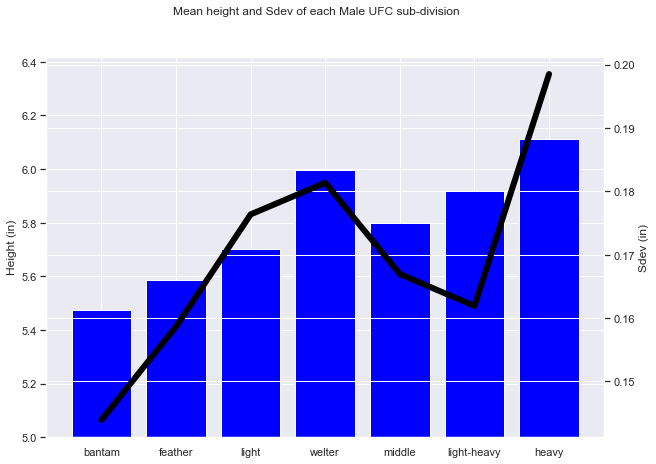

In [156]:
#figure settings
fig3, ax1 = plt.subplots(figsize=(10,7))
fig3.suptitle('Mean height and Sdev of each Male UFC sub-division')
ax2 = ax1.twinx()

ax1.set_ylabel('Height (in)')
ax2.set_ylabel('Sdev (in)')

#plotting graph

ordered_m_divisions = [bantamWeights, featherWeights, lightWeights, lightheavyWeights, welterWeights, middleWeights, heavyWeights]

mHeightMeans = []
mHeightStd = []
for dataset in ordered_m_divisions:
    mHeightMeans.append(dataset['height'].mean())
    mHeightStd.append(dataset['height'].std())

ax2.plot(mHeightStd, color="black",linewidth =6)
ax1.bar(['bantam','feather','light','welter','middle','light-heavy','heavy'],mHeightMeans, color="blue")
  
ax1.set_ylim(ymin=5);

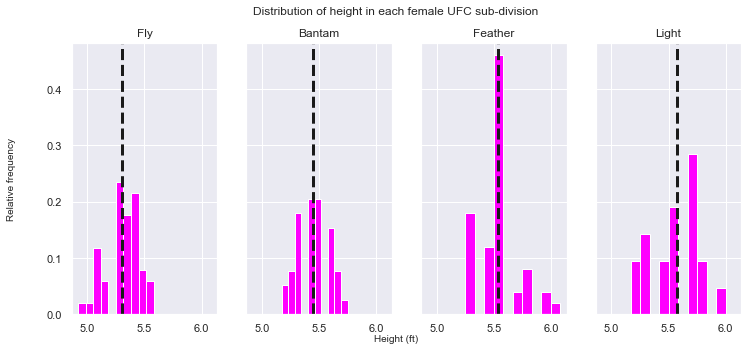

In [153]:
#figure settings
fig2, axes = plt.subplots(ncols=4, sharey=True, sharex=True,figsize=(12,5))
fig2.suptitle('Distribution of height in each female UFC sub-division')
suplabel('x','Height (ft)')
suplabel('y','Relative frequency')


#grouping by weight division

#plotting relative frequency
f_fly_division = femalesFrame[femalesFrame.division == 'fly']
axes[0].hist(f_fly_division['height'],weights=np.zeros_like(f_fly_division['height']) + 1./len(f_fly_division['height'].index),\
            color="magenta")
axes[0].title.set_text('Fly')
axes[0].axvline(f_fly_division['height'].mean(), color='k', linestyle='dashed', linewidth=3)

f_bantam_division = femalesFrame[femalesFrame.division == 'bantam']
axes[1].hist(f_bantam_division['height'],weights=np.zeros_like(f_bantam_division['height']) + 1./len(f_bantam_division['height'].index),\
            color="magenta")
axes[1].title.set_text('Bantam')
axes[1].axvline(f_bantam_division['height'].mean(), color='k', linestyle='dashed', linewidth=3)

f_feather_division = femalesFrame[femalesFrame.division == 'feather']
axes[2].hist(f_feather_division['height'],weights=np.zeros_like(f_feather_division['height']) + 1./len(f_feather_division['height'].index),\
            color="magenta")
axes[2].title.set_text('Feather')
axes[2].axvline(f_feather_division['height'].mean(), color='k', linestyle='dashed', linewidth=3)

f_light_division = femalesFrame[femalesFrame.division == 'light']
axes[3].hist(f_lightweight_division['height'],weights=np.zeros_like(f_lightweight_division['height']) + 1./len(f_lightweight_division['height'].index),\
            color="magenta")
axes[3].title.set_text('Light')
axes[3].axvline(f_lightweight_division['height'].mean(), color='k', linestyle='dashed', linewidth=3);

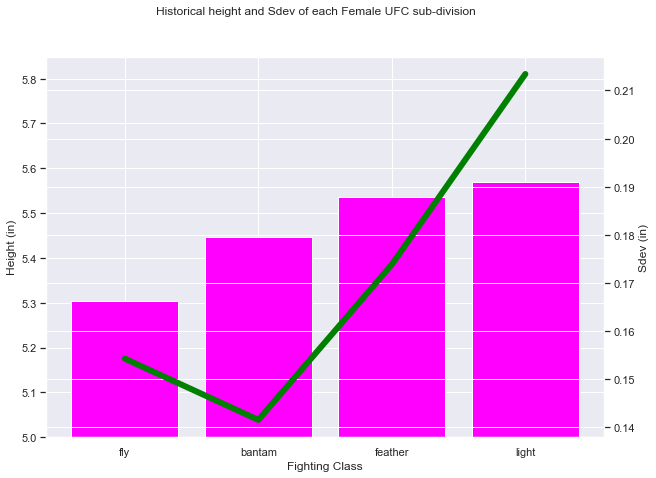

In [160]:
#females height summary
#figure settings
fig3, ax1 = plt.subplots(figsize=(10,7))
ax2 = ax1.twinx()
fig3.suptitle('Historical height and Sdev of each Female UFC sub-division')

ax1.set_xlabel('Fighting Class')
ax1.set_ylabel('Height (in)')
ax2.set_ylabel('Sdev (in)')

#plotting graph
ordered_f_divisions = [f_fly_division, f_bantam_division, f_feather_division, f_light_division]

fHeightMeans = []
fHeightStd = []
for dataset in ordered_f_divisions:
    fHeightMeans.append(dataset['height'].mean())
    fHeightStd.append(dataset['height'].std())

ax2.plot(fHeightStd, color="green",linewidth=6)
ax1.bar(['fly','bantam','feather','light'],fHeightMeans, color="magenta")
#ax1.bar(choices, heightMeans,color="#661122")   
ax1.set_ylim(ymin=5);

(array([ 2.,  2., 13., 13., 32., 58., 19., 26.,  3.,  5.]),
 array([64. , 65.4, 66.8, 68.2, 69.6, 71. , 72.4, 73.8, 75.2, 76.6, 78. ]),
 <a list of 10 Patch objects>)

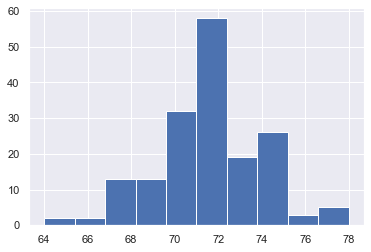

In [169]:
plt.hist(malesFrame[malesFrame.division == 'welter']['reach'])